# Energy Efficiency using TF Functional APIs


### Get Data - UCI.edu

In [1]:
import os
if(not os.path.exists('./data/ENB2012_data.xlsx')):
    !mkdir data
    os.chdir('./data')
    !curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx
    os.chdir('../')

### Read Data

In [2]:
import pandas as pd
df = pd.read_excel('./data/ENB2012_data.xlsx')
df = df.sample(frac=1).reset_index(drop=True)
print(len(df.columns))
df.head()

10


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.82,612.5,318.5,147.0,7.0,3,0.40,3,29.67,30.65
1,0.66,759.5,318.5,220.5,3.5,5,0.40,3,14.90,18.22
2,0.62,808.5,367.5,220.5,3.5,2,0.25,2,14.34,15.32
3,0.71,710.5,269.5,220.5,3.5,5,0.25,2,12.49,15.32
4,0.69,735.0,294.0,220.5,3.5,2,0.40,2,14.75,16.44


In [3]:
import numpy as np

### Split Data
def get_target_values(df):
    y1 = df.pop('Y1')
    y2 = df.pop('Y2')
    
    return np.array(y1), np.array(y2)

def norm(x, train_stats):
    return (x - train_stats['mean']) / train_stats['std']

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
train_stats = train.describe()

train_Y = get_target_values(train)
test_Y = get_target_values(test)


train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()

# Normalize the train and test data
norm_train_X = norm(train, train_stats)
norm_test_X = norm(test, train_stats)
 
print(norm_train_X.shape, norm_test_X.shape)




(614, 8) (154, 8)


In [5]:
## Build a TF model using Functional APIs

In [6]:
import tensorflow as tf

In [7]:
inp = tf.keras.layers.Input((len(train.columns),))
x = tf.keras.layers.Dense(128, activation='relu')(inp)
x = tf.keras.layers.Dense(128, activation='relu')(x)

In [8]:
y1_output = tf.keras.layers.Dense(1, name='y1_output')(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
y2_output = tf.keras.layers.Dense(1, name='y2_output')(x)

In [9]:
model = tf.keras.Model(inputs=inp, outputs=[y1_output, y2_output])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
_______________________________________________________________________________________

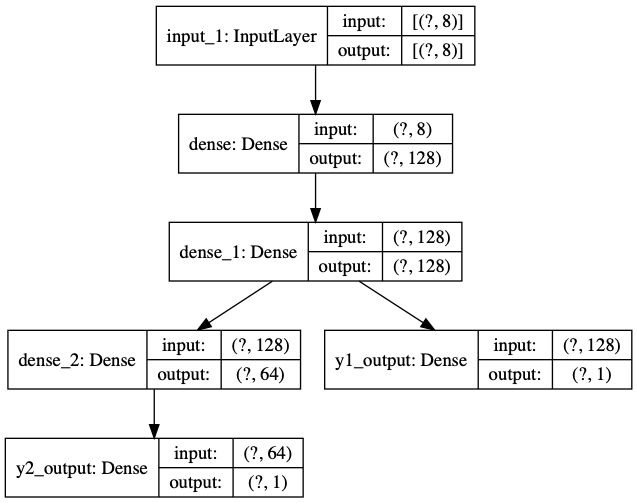

In [10]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={'y1_output': 'mse', 'y2_output': 'mse'},
    metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
           'y2_output': tf.keras.metrics.RootMeanSquaredError()}
)


In [12]:
history = model.fit(norm_train_X, train_Y,
    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y)
)

Epoch 1/500
62/62 [==============================] - 0s 6ms/step - loss: 744.7311 - y1_output_loss: 378.6125 - y2_output_loss: 366.1187 - y1_output_root_mean_squared_error: 19.4580 - y2_output_root_mean_squared_error: 19.1342 - val_loss: 167.5870 - val_y1_output_loss: 90.9348 - val_y2_output_loss: 76.6522 - val_y1_output_root_mean_squared_error: 9.5360 - val_y2_output_root_mean_squared_error: 8.7551
Epoch 2/500
62/62 [==============================] - 0s 1ms/step - loss: 79.0504 - y1_output_loss: 42.7162 - y2_output_loss: 36.3342 - y1_output_root_mean_squared_error: 6.5358 - y2_output_root_mean_squared_error: 6.0278 - val_loss: 54.4501 - val_y1_output_loss: 27.5689 - val_y2_output_loss: 26.8813 - val_y1_output_root_mean_squared_error: 5.2506 - val_y2_output_root_mean_squared_error: 5.1847
Epoch 3/500
62/62 [==============================] - 0s 1ms/step - loss: 47.1604 - y1_output_loss: 21.7726 - y2_output_loss: 25.3878 - y1_output_root_mean_squared_error: 4.6661 - y2_output_root_mean_s

In [13]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 914us/step - loss: 0.5847 - y1_output_loss: 0.1903 - y2_output_loss: 0.3943 - y1_output_root_mean_squared_error: 0.4363 - y2_output_root_mean_squared_error: 0.6280
Loss = 0.5846556425094604, Y1_loss = 0.1903200000524521, Y1_mse = 0.4362567961215973, Y2_loss = 0.39433565735816956, Y2_mse = 0.6279615163803101


In [14]:
import matplotlib.pyplot as plt
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

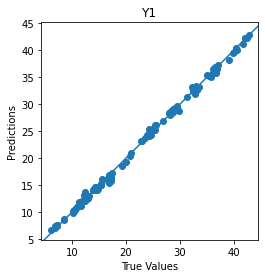

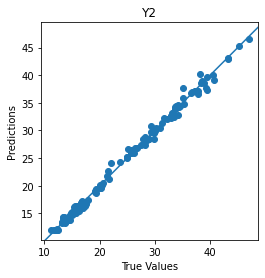

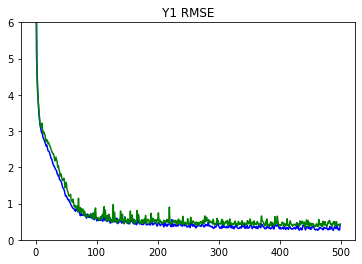

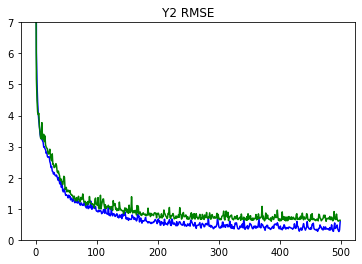

In [15]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)